#  Проект E-commerce: Выявление профилей потребления для интернет-магазина товаров для дома и быта *«Пока все ещё тут»*

## Материалы:
* [Презентация](https://drive.google.com/drive/folders/1-1Q12kojjUJcs9VLS_uJ_4N1VtybgBBu)

## Декомпозиция задачи анализа данных по профилю потребления в E-commerce

### Цели исследования
**Основная цель исследования:** Сегментировать покупателей на основе их истории покупок для разработки более персонализированных предложений. Также исследование направлено на решение следующих задач бизнеса:
1. **Рекомендации по маркетингу:** 
Исходя из анализа сегментов, разработать рекомендации о том, каким клиентам и когда следует рассылать рекламные предложения о каких категориях товаров.
2. **Стратегия увеличения продаж:**
Разработать стратегию по увеличению количества продаваемого товара для каждого сегмента.
3. **Стратегия повышения лояльности:**
Предложить способы повышения возвращаемости покупателей для различных сегментов.

### Предобработка данных
   - Проверить соответствие типов данных.
   - Проверка дубликатов.
   - Привести типы данных к нужному формату.
   - Исследовать и обработать пропущенные значения.
   - Построить ящики с усами для количественных переменных и выявить аномалии.
   - Создать столбец `product_full_price` с общей суммой заказанного товара
   - Создать столбец `month_year` с годом и месяцем заказа.

### Исследовательский анализ данных
- Вручную определить категории товаров и создать колонку `category`.
- Визуализировать кол-во проданных товаров по категориям в разрезе времени(по месяцам).
- Визуализировать динамику выручки в разрезе времени(по месяцам).
- Визуализировать динамику кол-ва заказов в разрезе времени с разделением по категориям.
- Визуализировать динамику среднего чека заказов в разрезе времени с разделением по категориям товаров.

### Основные вопросы исследования
- Провести предобработку данных для классификации на основе пороговых значений.
- Сделать классификацию.
- Создать колонку `clusters` c кластерами покупателей.
- Определить различия между кластерами(визуализировать графики среднего чека, кол-ва заказов, категорий покупаемых товаров для всех кластеров)


### Проверка гипотез
- Проверить следующие гипотезы с помощью ttest:

1. Первая гипотеза
**H_0:** Среднее количество заказов покупателей группы А равно среднему количеству заказов покупателей группы В.

$H_0: \mu_{заказы\ группы\ А} = \mu_{заказы\ группы\ В}$

**H_1:** Среднее количество заказов покупателей группы А не равно среднему количеству заказов покупателей группы В.

$H_1: \mu_{заказы\ группы\ А} \neq \mu_{заказы\ группы\ В}$

2. Вторая гипотеза
**H_0:** Средний чек покупателей группы B равен среднему чеку заказов покупателей группы C.

$H_0: \mu_{чек\ группы\ В} = \mu_{чек\ группы\ C}$

**H_1:** Средний чек заказов покупателей группы B не равен среднему чеку заказов покупателей группы C.

$H_1: \mu_{чек\ группы\ В} \neq \mu_{чек\ группы\ C}$

### Вывод
   - Сформулировать выводы по каждому сегменту покупателей.
   - Разработать рекомендации по персонализированным предложениям для каждого сегмента.
   - Подготовить презентацию с результатами исследования.

In [1]:
import pandas as pd
import numpy as np
import itertools
import warnings

import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Предобработка данных

### Загрузка данных, проверка на пропуски и дубликаты

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')

data_tables = {'data': data}

def data_preparation_func(data):
    for name, i in data.items():
        print(f"\033[1mИнформация по таблице {name}:\033[0m")
        i.info()
        duplicates = i.duplicated().sum()
        print(f"\033[1mКоличество дубликатов в таблице {name}:\033[1m \
        {duplicates}\n")
        
data_preparation_func(data_tables)

Информация по таблице data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB
Количество дубликатов в таблице data:         0



> Дубликатов и пропусков, к счастью, не обнаружено, однако обнаружены неправильные типы данных у столбцов.

### Описание данных

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока
все ещё тут».
Колонки в /datasets/ecom_dataset_upd.csv :
- `date` — дата заказа, тип данных: int64;  
- `customer_id` — идентификатор покупателя, тип данных: object;  
- `order_id` — идентификатор заказа, тип данных: int64;  
- `product` — наименование товара, тип данных: object;  
- `quantity` — количество товара в заказе, тип данных: int64;  
- `price` — цена товара, тип данных: float64;

### Преобразуем типы данных в столбцах

Столбцы на замену  
**data:**
- *date* — дата, когда был совершён заказ, тип данных: int64, тип данных неверный для даты, нужно заменить на datetime64[ns];

In [3]:
# преобразуем стодбец 'date' 
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')
print(data.dtypes)

date           datetime64[ns]
customer_id            object
order_id                int64
product                object
quantity                int64
price                 float64
dtype: object


### Ящики с усами для количественных переменных


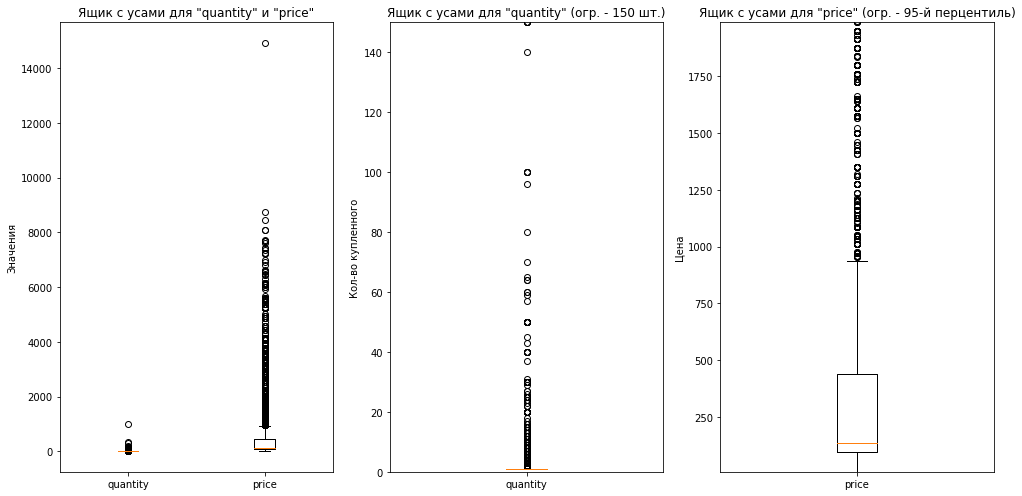

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(14, 7))

axes[0].boxplot([data['quantity'], data['price']], labels=['quantity', 'price'])
axes[0].set_title('Ящик с усами для "quantity" и "price"')
axes[0].set_ylabel('Значения')

axes[1].boxplot(data['quantity'], labels=['quantity'])
axes[1].set_ylim(0, 150)
axes[1].set_title('Ящик с усами для "quantity" (огр. - 150 шт.)')
axes[1].set_ylabel('Кол-во купленного')

axes[2].boxplot(data['price'], labels=['price'])
axes[2].set_ylim(data['price'].quantile(0.0), data['price'].quantile(0.95))
axes[2].set_title('Ящик с усами для "price" (огр. - 95-й перцентиль)')
axes[2].set_ylabel('Цена')

plt.tight_layout()
plt.show()

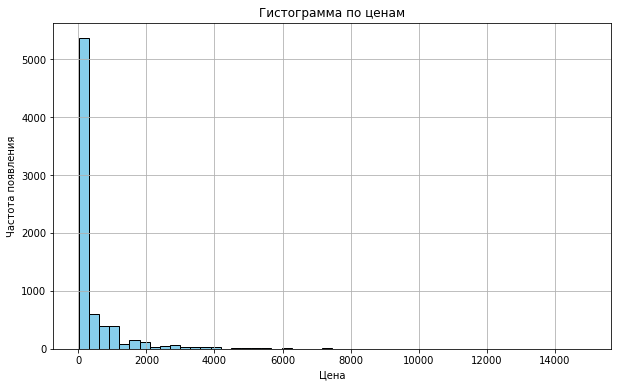

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(data['price'], bins=50, color='skyblue', edgecolor='black')
plt.title('Гистограмма по ценам')
plt.xlabel('Цена')
plt.ylabel('Частота появления')
plt.grid(True)
plt.show()

In [6]:
print(f"Минимальная цена: {data['price'].min()}")
print(f"Максимальная цена: {data['price'].max()}")

Минимальная цена: 9.0
Максимальная цена: 14917.0


In [7]:
print(f"\033[1mТовары по {data['price'].min()} руб.:\033[0m {list(data[data['price'] == data['price'].min()]['product'])}\n")
print(f"\033[1mТовары по {data['price'].max()} руб.:\033[0m {list(data[data['price'] == data['price'].max()]['product'])}")

Товары по 9.0 руб.: ['Алиссум (лобулярия) Снежные одежды 0,2 г 4650091480302', 'Львиный зев Волшебный ковер 0,05 г 4660010779639', 'Горох Амброзия 10,0 г 4660010772616', 'Алиссум (лобулярия) Снежные одежды 0,2 г 4650091480302', 'Львиный зев Волшебный ковер 0,05 г 4660010779639']

Товары по 14917.0 руб.: ['Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая']


In [8]:
data = data[data['quantity'] !=1000]

> На ящиках и на гистограмме видно, что **в переменных много выбросов**. Однако для столбца `quantity`, скорее всего, это **означает другую категорию покупателей, которая по кол-ву покупок отличается от общей массы, то есть, оптовиков**. Но все-таки был удален самый значимый выброс в 1000 шт., чтобы избежать искажения результатов исследования.   
Для столбца `price` тоже все логично: **товаров по дорогим ценам меньше, чем по низким, и они соответствуют своей цене**.

### Создание столбцов product_full_price и month_year

In [9]:
warnings.filterwarnings('ignore')

data.loc[:, 'product_full_price'] = data['price'] * data['quantity']

data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')
data.loc[:, 'year_month'] = data['date'].dt.to_period('M')
data.head()

,date,customer_id,order_id,product,quantity,price,product_full_price,year_month
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,2018-10
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,2018-10
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,2018-10
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,2018-10
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,2018-10


### Мини-итог
- Были импортированы данные для анализа, таблица: **ecom_dataset_upd.csv**  
- **Проведена обработка(чистка от пропусков, проверка на дубликаты, преобразование типов данных столбцов)**:  

  *date* — дата, когда был совершён заказ, тип данных: int64, тип данных неверный для даты, нужно заменить на datetime64[ns];  
- Проведена **проверка на выбросы в столбцах `quantity` и `price`, аномалий не обнаружено.**  
- **Созданы столбцы** `product_full_price` и  `year_month`.

## Исследовательский анализ данных


### Определение категорий товаров и создание столбца category

In [10]:
for i in data['product'].unique():
    print(i)

Комнатное растение в горшке Алое Вера, d12, h30
Комнатное растение в горшке Кофе Арабика, d12, h25
Радермахера d-12 см h-20 см
Хризолидокарпус Лутесценс d-9 см
Циперус Зумула d-12 см h-25 см
Шеффлера Лузеана d-9 см
Юкка нитчатая d-12 см h-25-35 см
Настенная сушилка для белья Gimi Brio Super 100
Таз пластмассовый 21,0 л круглый "Водолей" С614, 1404056
Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379
Вешалка для брюк металлическая с резиновым покрытием 26 см цвет: синяя, Attribute, AHS331
Сушилка для белья потолочная Zalger Lift Basic 1520 200 см, 10 м
Чехол Eurogold Clean Basic хлопок для досок 120х38-120х42 см C42
Крючок одежный 2-х рожковый серый металлик с полимерным покрытием *Тонар*, 1110027
Корзина мягкая пластиковая 17 л, М-пластика, M2880
Мини-сковорода Marmiton "Сердце" с антипригарным покрытием 12 см, LG17085
Сковорода алюминиевая с антипригарным покрытием MARBLE ALPENKOK d = 26 см AK-0039A/26N
Стеклянная крышка для сковороды ALPENKOK 26 см AK-26GL
Суши

In [11]:
def categorize_product(product):
    product_lower = product.lower()
    if any(keyword in product_lower for keyword in ['растение', 'цветок', 'рассада', 'горшок', 'кашпо', 'сад', 'радермахера', 
                                                    'хризолидокарпус', 'циперус', 'шеффлера', 'юкка', 'герань', 'пеларгония', 
                                                    'суккулент', 'кампанула', 'эхеверия', 'адиантум', 'бакопа', 'лаванда', 
                                                    'помидор', 'калибрахоа', 'петуния', 'эвкалипт', 'калатея', 'нолина', 
                                                    'хлорофитум', 'цикламен', 'глоксиния', 'азалия', 'гортензия', 'хризантема',
                                                    'калатея', 'мирт', 'иссоп', 'сантолина', 'аспарагус', 'антуриум', 
                                                    'молодило', 'фиалка', 'гербера', 'душица', 'мелисса', 'роза', 'розмарин', 
                                                    'амариллис', 'тимьян', 'фуксия', 'шалфей', 'цинерария', 'петрушка', 
                                                    'любисток', 'сельдерей' ,'капуста', 'бегония', 'капсикум', 'каллуна', 
                                                    'калоцефалус', 'дендробиум', 'вербена', 'альбука', 'бальзамин', 'крассула',
                                                    'артемизия', 'мята', 'каланхое', 'примула', 'мимоза', 'соланум', 'дерево', 
                                                    'пуансеттия', 'аптения', 'гиностемма', 'бархатцы', 'космея', 'морковь', 
                                                    'настурция', 'огурец', 'алиссум', 'гвоздика', 'годеция', 'календула', 
                                                    'кореопсис', 'лапчатка', 'флокс', 'эшшольция', 'фаленопсис', 'подсолнечник',
                                                    'пуансетия', 'скиммия', 'фиттония', 'алоэ', 'спатифиллум', 'фикус', 
                                                    'лиана', 'кодонанта', 'фаленопсис', 'гимнокалициум', 'эхинокактус', 'фал', 
                                                    'крокусы', 'гипсофила', 'эпипремнум', 'фаленопсис', 'аквилегия', 'базилик',
                                                    'горох', 'земляника', 'незабудка', 'седум', 'томат', 'укроп', 'нефролепис',
                                                    'баклажан', 'арбуз', 'вероника', 'спатифиллум', 'декабрист', 'муррайя', 
                                                    'пиретрум', 'мускари', 'нефролепис', 'калла', 'тюльпан', 'искусственная', 
                                                    'гиацинт', 'чабер', 'ранункулус', 'георгина', 'смолевка', 'цинния', 
                                                    'базилик', 'лавр', 'вербейник', 'колокольчик', 'котовник', 'эхинацея', 
                                                    'ясколка', 'афеляндра', 'виола', 'лилейник', 'папоротник', 'платикодон', 
                                                    'энотера', 'цитрофортунелла', 'пеперомия', 'дыня', 'гардения', 'лобелия', 
                                                    'виноград', 'клубника', 'патиссон', 'лук', 'джункус', 'драцена', 'фатсия', 
                                                    'хоста', 'гайлардия', 'монарда', 'нивянник', 'рудбекия', 'барвинок', 
                                                    'осина', 'вербейник', 'физостегия', 'змееголовник', 'литопс', 'пахира',
                                                    'салат', 'замиокулькас', 'клен', 'импатиенс', 'мединилла', 'зверобой', 
                                                    'хамедорея', 'тыква', 'кабачок', 'монарда', 'змееголовник', 'валериана', 
                                                    'буддлея', 'анемона', 'лаватера', 'клена', 'лантана', 'сциндапсус', 
                                                    'пряные', 'камнеломка', 'солидаго', 'бадан', 'лен', 'астра']):
        return 'Сад и огород'
    elif any(keyword in product_lower for keyword in ['миксер', 'холодильник', 'микроволновка', 
                                                      'телевизор', 'утюг', 'пылесос', 'котел', 'кипятильник']):
        return 'Бытовая техника'
    elif any(keyword in product_lower for keyword in ['кастрюля', 'сковорода', 'нож', 'ложка', 'вилка', 'крышка', 'тарелка',
                                                      'кувшин', 'чашка', 'стакан', 'чайник', 'муляж', 'банка', 'толкушка', 
                                                      'противень', 'блюдце', 'кружка', 'салатник', 'вкладыши', 'кориандр', 
                                                      'подрукавник', 'рыбочистка', 'овощеварка', 'лоток', 'терка', 
                                                      'салфетница', 'овощечистка', 'мантоварка', 'термос', 'пресс', 'кисточка',
                                                      'скребок', 'картофелемялка', 'миска', 'электроштопор', 'бульонница',
                                                      'емкость', 'просеиватель', 'хлебница', 'салфетки', 'кофе', 'выпечки', 
                                                      'орехоколка', 'скалка', 'венчик', 'сито', 'овсянница', 'тортница', 
                                                      'блюдо', 'половник', 'соковыжималка', 'соковарка', 'сахарница',
                                                      'отделитель']):
        return 'Кухонная утварь'
    elif any(keyword in product_lower for keyword in ['сушилка', 'сушилка уличная', 'щетка', 'коврик', 'корзина', 'доска', 'чехол', 'сумка',
                                                      'ёрш', 'ерш', 'крючок', 'салфетка', 'подставка', 'плед', 'скатерть',
                                                      'тележка', 'вешалка', 'таз', 'ванной', 'простыня', 'ковер', 'набор', 
                                                      'контейнер', 'штора', 'швабра', 'полотенце', 'дозатор', 'плечики', 
                                                      'крем', 'паста', 'термометр', 'комод', 'прищепки', 'полки', 'табак', 
                                                      'декоративная', 'подушка', 'кофр', 'стиральный', 'светильник', 'мыло', 
                                                      'ковёр', 'пена', 'веник', 'ящик', 'ведро', 'короб', 'коробка',
                                                      'наматрасник', 'масленка', 'корыто', 'урна', 'фен', 'губка', 'вешалки',
                                                      'сметка', 'халат', 'держатель', 'пробка', 'ролик', 'вантуз', 'фоторамка',
                                                      'кольца', 'комплект', 'мыльница', 'весы', 'блок', 'ковш', 'бальзам', 
                                                      'сетка', 'покрывало', 'одеяло', 'подголовник', 'кондиционер', 'простынь',
                                                      'ключница', 'соль', 'гель', 'маска', 'рукав', 'бак', 'концентрат', 
                                                      'полка', 'ткань', 'наматрацник', 'наволочка', 'обувница-3',
                                                      'пододеяльник', 'отжим', 'стяжки', 'белье', 'совок', 'стеллаж',
                                                      'тряпка', 'пакет', 'этажерка', 'пьезозажигалка', 'покрытие', 'бидон',
                                                      'мешок', 'ванна', 'пуф']):
        return 'Товары для дома'
    else:
        return 'Инструменты и оборудование'

# Применим функцию к колонке product и создадим новую колонку category
data.loc[:, 'category'] = data['product'].apply(categorize_product)
data['category'].value_counts()

Сад и огород                  4708
Товары для дома               2040
Кухонная утварь                561
Инструменты и оборудование     153
Бытовая техника                 11
Name: category, dtype: int64

> Было определено **5 категорий: Сад и огород, Товары для дома, Бытовая техника, Кухонная утварь, Инструменты и оборудование**

### Графики дохода, кол-ва заказов, среднего чека и кол-ва проданных товаров по месяцам 

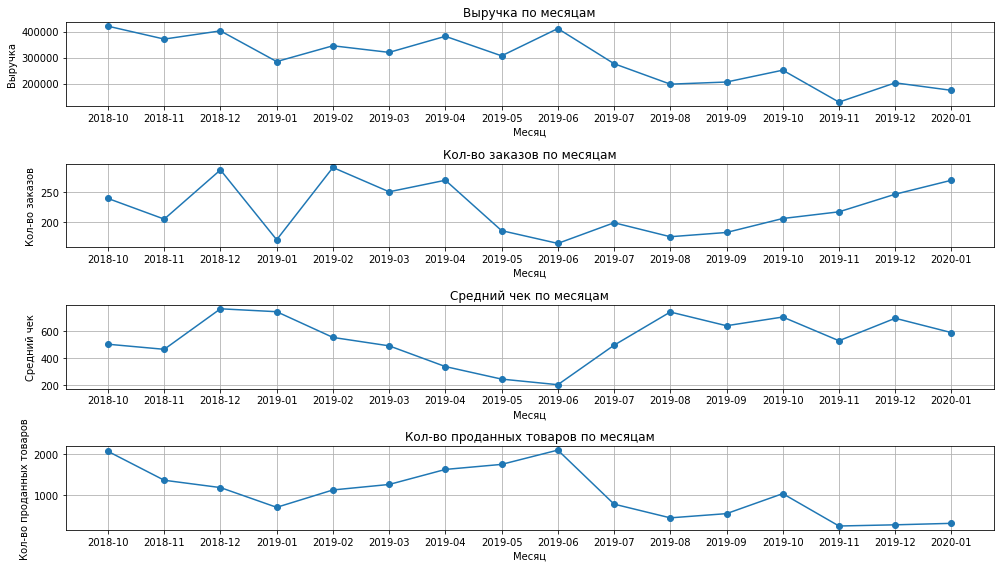

In [12]:
# доход
revenue = data.groupby('year_month')['product_full_price'].sum()

# кол-во заказов
order_quantity = data.groupby('year_month')['order_id'].nunique()

# средний чек по месяцам
order_summary = data.groupby('order_id').agg({'price': 'sum', 'quantity': 'sum'}).reset_index()
order_summary['avg_check'] = order_summary['price'] / order_summary['quantity']

data = pd.merge(data, order_summary[['order_id', 'avg_check']], on='order_id', how='left')

avg_check_by_month = data.groupby('year_month')['avg_check'].mean().reset_index()
avg_check_by_month['year_month'] = avg_check_by_month['year_month'].astype(str)

# кол-во проданных товаров по месяцам
sold_items = data.groupby('year_month')['quantity'].sum()


fig, axs = plt.subplots(4, 1, figsize=(14, 8))

axs[0].plot(revenue.index.astype(str), revenue, marker='o')
axs[0].set_title('Выручка по месяцам')
axs[0].set_xlabel('Месяц')
axs[0].set_ylabel('Выручка')
axs[0].grid(True)

axs[1].plot(order_quantity.index.astype(str), order_quantity, marker='o')
axs[1].set_title('Кол-во заказов по месяцам')
axs[1].set_xlabel('Месяц')
axs[1].set_ylabel('Кол-во заказов')
axs[1].grid(True)

axs[2].plot(avg_check_by_month['year_month'], avg_check_by_month['avg_check'], marker='o')
axs[2].set_title('Средний чек по месяцам')
axs[2].set_xlabel('Месяц')
axs[2].set_ylabel('Средний чек')
axs[2].grid(True)

axs[3].plot(sold_items.index.astype(str), sold_items, marker='o')
axs[3].set_title('Кол-во проданных товаров по месяцам')
axs[3].set_xlabel('Месяц')
axs[3].set_ylabel('Кол-во проданных товаров')
axs[3].grid(True)

plt.tight_layout()
plt.show()

In [13]:
data[data['product_full_price'] == data['product_full_price'].max()][['date', 'product', 'quantity']]

,date,product,quantity
5071,2019-06-11 07:00:00,Вешалки мягкие для деликатных вещей 3 шт шоколад,334


> **Выручка по месяцам:** Из графика видно, что **общая выручка постепенно падает.**   

> **Кол-во заказов по месяцам:** До начала 2019 года кол-во заказов **сильно колебалось, однако все же сильно упало к июню 2019**. Затем заказы **постепенно начали расти и продолжают расти до конца предоставленных данных.**  

> **Средний чек по месяцам:** Как правило, в **осенний и зимний период средний чек намного выше, чем в летний и весенний**, так как **в теплые сезоны происходит закупка семенами**, а они очень **дешевые и не увеличивают средний чек(около 200-300 руб). Заметно сильное повышение в период на декабрь: люди закупаются подарками(около 700-800 руб).**  

> **Кол-во проданных товаров по месяцам:** Ситуация координально отличается от предыдущего графика: **в холодные сезоны кол-во проданных товаров низкое**, люди покупают практически поштучно, а **ближе к лету продается много товаров**, скорее всего все закупаются семенами и товарами для огорода. 

### Графики дохода, кол-ва заказов, среднего чека и кол-ва проданных товаров по месяцам (разделение по категориям товаров)

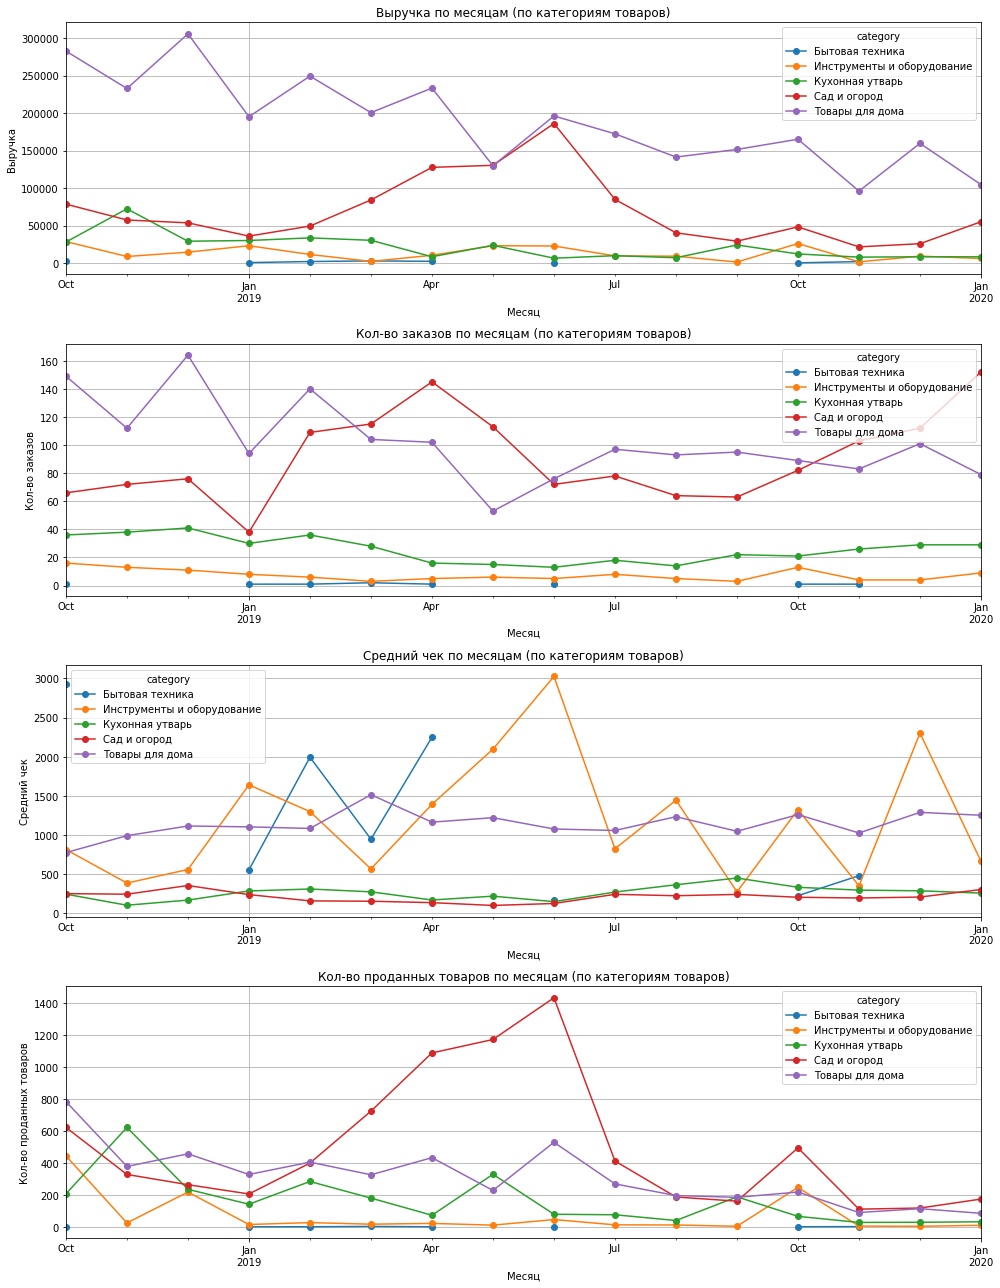

In [14]:
# Выручка по категориям
revenue_by_category = data.groupby(['year_month', 'category'])['product_full_price'].sum().unstack()

# Кол-во заказов по категориям
orders_by_category = data.groupby(['year_month', 'category'])['order_id'].nunique().unstack()

# Средний чек по категориям
order_summary = data.groupby(['order_id', 'category']).agg({'price': 'sum', 'quantity': 'sum'}).reset_index()
order_summary['avg_check'] = order_summary['price'] / order_summary['quantity']


data = pd.merge(data, order_summary[['order_id', 'category']], on=['order_id', 'category'], how='left')

avg_check_by_category = data.groupby(['year_month', 'category'])['avg_check'].mean().unstack()

# Кол-во проданных товаров по категориям
sold_items_by_category = data.groupby(['year_month', 'category'])['quantity'].sum().unstack()

# Выручка и средний чек по покупателям (customer_id) по месяцам
revenue_by_customer_monthly = data.groupby(['year_month', 'customer_id'])['product_full_price'].sum().unstack()
avg_check_by_customer_monthly = data.groupby(['year_month', 'customer_id']).apply(
    lambda x: x['product_full_price'].sum() / x['order_id'].nunique()
).unstack()

fig, axs = plt.subplots(4, 1, figsize=(14, 18))

revenue_by_category.plot(kind='line', marker='o', ax=axs[0])
axs[0].set_title('Выручка по месяцам (по категориям товаров)')
axs[0].set_xlabel('Месяц')
axs[0].set_ylabel('Выручка')
axs[0].grid(True)

orders_by_category.plot(kind='line', marker='o', ax=axs[1])
axs[1].set_title('Кол-во заказов по месяцам (по категориям товаров)')
axs[1].set_xlabel('Месяц')
axs[1].set_ylabel('Кол-во заказов')
axs[1].grid(True)

avg_check_by_category.plot(kind='line', marker='o', ax=axs[2])
axs[2].set_title('Средний чек по месяцам (по категориям товаров)')
axs[2].set_xlabel('Месяц')
axs[2].set_ylabel('Средний чек')
axs[2].grid(True)

sold_items_by_category.plot(kind='line', marker='o', ax=axs[3])
axs[3].set_title('Кол-во проданных товаров по месяцам (по категориям товаров)')
axs[3].set_xlabel('Месяц')
axs[3].set_ylabel('Кол-во проданных товаров')
axs[3].grid(True)


plt.tight_layout()
plt.show()

> **Выручка по месяцам (по категориям товаров):** **Самые стабильные категории товаров: "Кухонная утварь" и "Инструменты и оборудование".** **К Новому Году выручку поднимает "Бытовая техника",** а категория **"Сад и огород" сильно растет в период весна-начало лета.**  

> **Кол-во заказов по месяцам (по категориям товаров):** Категории **"Бытовая техника", "Кухонная утварь" и "Инструменты и оборудование" достаточно стабильны в течение года в плане заказов**. **"Товары для дома" лучше продаются в период осень-декабрь, а "Сад и огород" с марта по июнь(до 140).**  

> **Средний чек по месяцам (по категориям товаров):** Самые стабильные категории в плане среднего чека: **"Кухонная утварь" и "Сад и огород", они стабильно низкие - около 250-500 рублей.** **"Товары для дома" тоже стабильны, но со средним чеком в 800-1000 руб.** Ср. чек категории **"Инструменты и оборудование"** сильно колебается в течении года, из-за того, что таких заказов меньше, **пики приходятся на июнь(3000 руб.) и декабрь(2300 руб.)**. **"Бытовая техника" колеблется от 1250 до 2500, пик приходится на декабрь.**  

> **Кол-во проданных товаров по месяцам (по категориям товаров):** Все категории более-менее стабильны, только **заметны всплески у "Инструменты и оборудование" в октябре, "Кухонная утварь"** и постепенное **вырастание кол-ва проданного категории "Сад и огород" с января по июнь и в октябре.**

### Топ покупателей по выручке и по среднему чеку

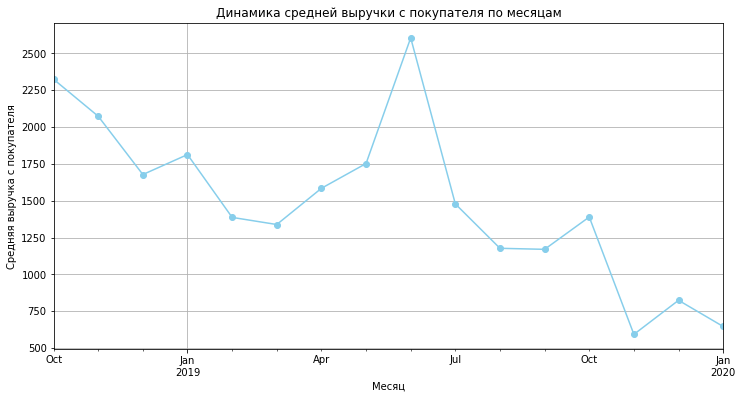

In [15]:
# Расчет средней выручки с покупателя по месяцам
monthly_revenue_per_customer = data.groupby(['year_month', 'customer_id'])['product_full_price'].sum().groupby(level=0).mean()

plt.figure(figsize=(12, 6))
monthly_revenue_per_customer.plot(kind='line', marker='o', color='skyblue')
plt.title('Динамика средней выручки с покупателя по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средняя выручка с покупателя')
plt.grid(True)
plt.show()

In [16]:
total_revenue_per_customer = data.groupby('customer_id')['product_full_price'].sum()
data['total_amount'] = data.groupby('customer_id')['price'].transform('sum')

top_5_customers = total_revenue_per_customer.sort_values(ascending=False).head(5).index

top_5_customers_data = data[data['customer_id'].isin(top_5_customers)]

top_5_customers_data.drop_duplicates(subset='customer_id', inplace=True)
top_5_customers_data = top_5_customers_data.sort_values(by='total_amount', ascending=False)
top_5_customers_data[['date', 'customer_id', 'avg_check', 'total_amount']]

,date,customer_id,avg_check,total_amount
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,674.000000,134145.0
4157,2019-05-31 12:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,125.800000,113220.0
2589,2019-04-01 16:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,1087.000000,65220.0
12,2018-10-01 13:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,187.000000,30539.0
1469,2019-01-10 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,649.666667,3704.0


> **Основной тренд - сильное падение средней выручки.** Выручка росла с весны по июнь 2019, так как в целом в этот период больше продаж.  
> **Самая высокая прибыль по покупателем наблюдается среди покупателей со средним чеком от 100-1000 руб. Самая высокая выручка от покупателя: 134145 руб.**  

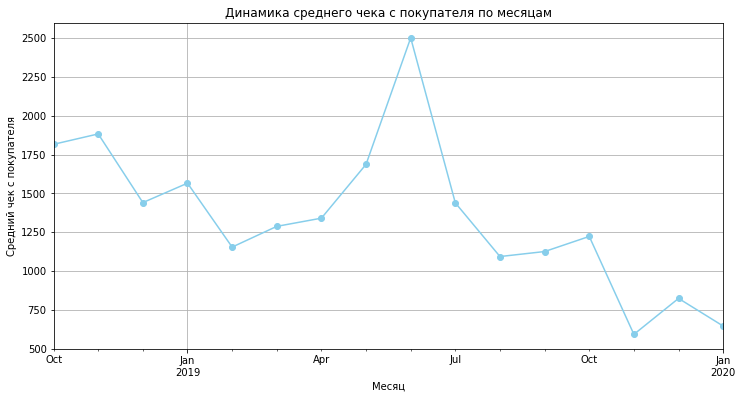

In [17]:
# Расчет среднего чека с покупателя по месяцам
monthly_avg_check_per_customer = data.groupby(['year_month', 'customer_id']).apply(
    lambda x: x['product_full_price'].sum() / x['order_id'].nunique()
).groupby(level=0).mean()

plt.figure(figsize=(12, 6))
monthly_avg_check_per_customer.plot(kind='line', marker='o', color='skyblue')
plt.title('Динамика среднего чека с покупателя по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средний чек с покупателя')
plt.grid(True)
plt.show()

In [18]:
top_5_customers = data.sort_values(by='avg_check', ascending=False).head(5)


top_5_customers

,date,customer_id,order_id,product,quantity,price,product_full_price,year_month,category,avg_check,total_amount
5991,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400...,1,14917.0,14917.0,2019-07,Сад и огород,14917.0,14917.0
2697,2019-04-05 19:00:00,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,Сумка-тележка хозяйственная Andersen Royal Sho...,1,8737.0,8737.0,2019-04,Товары для дома,8737.0,8737.0
1981,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,Сумка-тележка хозяйственная Andersen Alu Star ...,1,8437.0,8437.0,2019-02,Товары для дома,8437.0,8684.0
2997,2019-04-21 16:00:00,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,Сумка-тележка хозяйственная Rolser MNB019 rojo...,1,8077.0,8077.0,2019-04,Товары для дома,8077.0,8167.0
7435,2020-01-26 19:00:00,04416514-5346-4f90-93e3-fb7365e2ee8c,109758,Сумка-тележка хозяйственная Rolser MNB019 rojo...,1,8077.0,8077.0,2020-01,Товары для дома,8077.0,8107.0


> **Ситуация как и с выручкой: наблюдается снижение среднего чека.**  
> **Самый высокий ср.чек по покупателем наблюдается среди единоразовых покупок покупателей, которые купили дорогой товар. Самый высокий ср.чек: 14917 руб.**

### Мини-итог
1. Было определено **5 категорий: Сад и огород, Товары для дома, Бытовая техника, Кухонная утварь, Инструменты и оборудование**   

2. ***Графики без разбивки по категориям:***  
- ***Выручка по месяцам:*** Из графика видно, что **общая выручка постепенно падает.**  


- ***Кол-во заказов по месяцам:*** До начала 2019 года кол-во заказов **сильно колебалось, однако все же сильно упало к июню 2019**. Затем заказы **постепенно начали расти и продолжают расти до конца предоставленных данных.**  


- ***Средний чек по месяцам:*** Как правило, в **осенний и зимний период средний чек намного выше, чем в летний и весенний**, так как **в теплые сезоны происходит закупка семенами**, а они очень **дешевые и не увеличивают средний чек(около 200-300 руб). Заметно сильное повышение в период на декабрь: люди закупаются подарками(около 700-800 руб).**  


- ***Кол-во проданных товаров по месяцам:*** Ситуация координально отличается от предыдущего графика: **в холодные сезоны кол-во проданных товаров низкое**, люди покупают практически поштучно, а **ближе к лету продается много товаров**, скорее всего все закупаются семенами и товарами для огорода. 

3. ***Графики с разбивкой по категориям:***  
- ***Выручка по месяцам (по категориям товаров):*** **Самые стабильные категории товаров: "Кухонная утварь" и "Инструменты и оборудование".** **К Новому Году выручку поднимает "Бытовая техника",** а категория **"Сад и огород" сильно растет в период весна-начало лета.**  


- ***Кол-во заказов по месяцам (по категориям товаров):*** Категории **"Бытовая техника", "Кухонная утварь" и "Инструменты и оборудование" достаточно стабильны в течение года в плане заказов**. **"Товары для дома" лучше продаются в период осень-декабрь, а "Сад и огород" с марта по июнь(до 140).  


- ***Средний чек по месяцам (по категориям товаров):*** Самые стабильные категории в плане среднего чека: **"Кухонная утварь" и "Сад и огород", они стабильно низкие - около 250-500 рублей.** **"Товары для дома" тоже стабильны, но со средним чеком в 800-1000 руб.** Ср. чек категории **"Инструменты и оборудование"** сильно колебается в течении года, из-за того, что таких заказов меньше, **пики приходятся на июнь(3000 руб.) и декабрь(2300 руб.)**. **"Бытовая техника" колеблется от 1250 до 2500, пик приходится на декабрь.**  


- ***Кол-во проданных товаров по месяцам (по категориям товаров):*** Все категории более-менее стабильны, только **заметны всплески у "Инструменты и оборудование" в октябре, "Кухонная утварь"** и постепенное **вырастание кол-ва проданного категории "Сад и огород" с января по июнь и в октябре.**  

4. ***Топ покупателей по выручке и по среднему чеку:***  
- **Основной тренд - сильное падение средней выручки.** Выручка росла с весны по июнь 2019, так как в целом в этот период больше продаж.  
- **Самая высокая прибыль по покупателем наблюдается среди покупателей со средним чеком от 100-1000 руб. Самая высокая выручка от покупателя: 134145 руб.**  

- **Ситуация как и с выручкой: наблюдается снижение среднего чека.**  
- **Самый высокий ср.чек по покупателем наблюдается среди единоразовых покупок покупателей, которые купили дорогой товар. Самый высокий ср.чек: 14917 руб.**

## Основные вопросы исследования

### Предобработка данных и классификация на основе пороговых значений

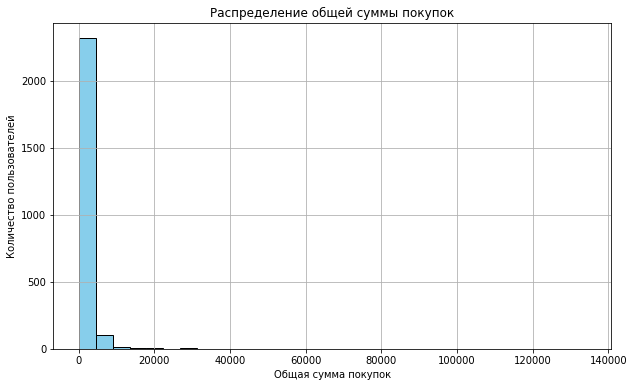

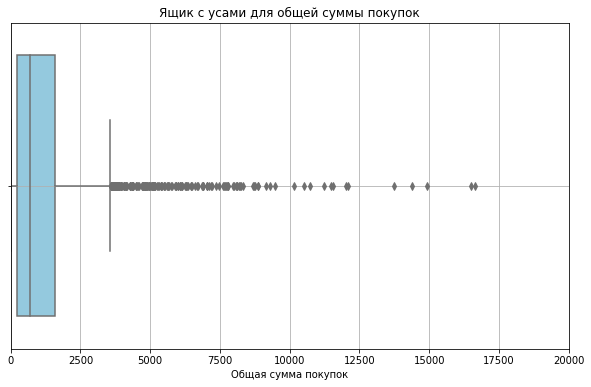

In [19]:
unique_customers_data = data.drop_duplicates(subset=['customer_id'])

# Расчет параметров для каждого уникального пользователя

# Общее количество заказов
unique_customers_data['total_purchases'] = data.groupby('customer_id')['order_id'].transform('nunique')

# Общая сумма покупок
unique_customers_data['total_amount'] = data.groupby('customer_id')['price'].transform('sum')

# Средняя сумма покупки
unique_customers_data['avg_purchase_amount'] = unique_customers_data['total_amount'] / unique_customers_data['total_purchases']

# Частота покупок
unique_customers_data['days_since_first_purchase'] = (data['date'] - data.groupby('customer_id')['date'].transform('min')).dt.days
unique_customers_data['purchase_frequency'] = unique_customers_data['total_purchases'] / (unique_customers_data['days_since_first_purchase'] + 1)


plt.figure(figsize=(10, 6))
plt.hist(unique_customers_data['total_amount'], bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение общей суммы покупок')
plt.xlabel('Общая сумма покупок')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.show()

# Построение boxplot для total_amount
plt.figure(figsize=(10, 6))
sns.boxplot(x=unique_customers_data['total_amount'], color='skyblue')
plt.title('Ящик с усами для общей суммы покупок')
plt.xlabel('Общая сумма покупок')
plt.xlim(0, 20000)
plt.grid(True)
plt.show()

In [20]:
# Определение порогов для кластеров на основе общей суммы покупок
threshold_1 = 1000
threshold_2 = 5000

def determine_cluster(row):
    if row['total_amount'] < threshold_1:
        return 0  
    elif row['total_amount'] < threshold_2:
        return 1  
    else:
        return 2  

unique_customers_data['cluster'] = unique_customers_data.apply(determine_cluster, axis=1)

print('Статистика по средним значениям')
print(unique_customers_data.groupby('cluster').mean())

Статистика по средним значениям
             order_id  quantity        price  product_full_price    avg_check  \
cluster                                                                         
0        64743.278993  4.874751   263.925779          623.453943   225.024079   
1        64673.593486  1.238842  1299.026538         1444.428227  1258.896034   
2        67796.616071  1.089286  3732.464286         3849.142857  3694.511603   

         total_amount  total_purchases  avg_purchase_amount  \
cluster                                                       
0          382.328142         1.286282           312.514634   
1         2076.799055         1.529554          1514.219807   
2        11417.941964         3.071429          7982.586646   

         days_since_first_purchase  purchase_frequency  
cluster                                                 
0                              0.0            1.286282  
1                              0.0            1.529554  
2                 

> Была создана **классификация на основе пороговых значений**

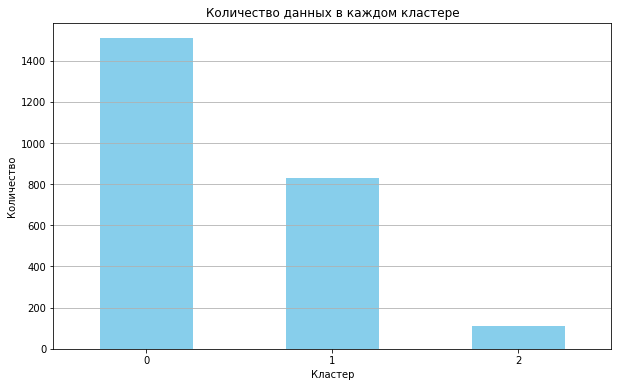

In [21]:
# визуализация кол-ва покупателей по категориям
cluster_counts = unique_customers_data['cluster'].value_counts()

plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Количество данных в каждом кластере')
plt.xlabel('Кластер')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [22]:
unique_customers_data['cluster'].value_counts()

0    1509
1     829
2     112
Name: cluster, dtype: int64

> **Самая многочисленная категория покупателей: 0 - 1509**, затем 1 - 829 и 2 - 112.

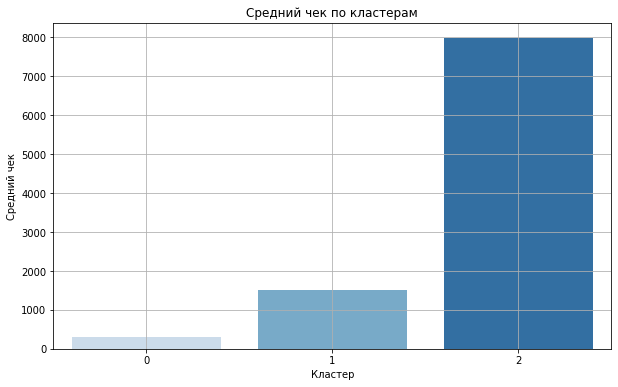

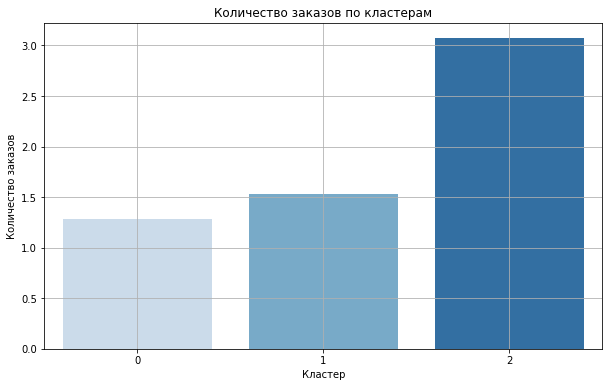

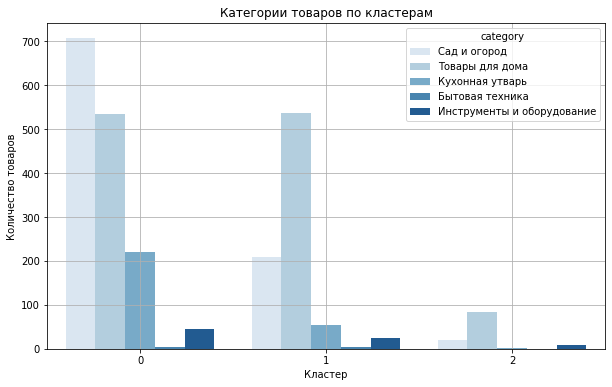

In [23]:
# Средний чек по кластерам
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='avg_purchase_amount', data=unique_customers_data, palette='Blues', ci=None)
plt.title('Средний чек по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Средний чек')
plt.grid(True)
plt.show()

# Количество заказов по кластерам
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='total_purchases', data=unique_customers_data, palette='Blues', ci=None)
plt.title('Количество заказов по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

# Категории товаров по кластерам
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', hue='category', data=unique_customers_data, palette='Blues')
plt.title('Категории товаров по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Количество товаров')
plt.grid(True)
plt.show()

По итогам составленных визуализаций можно определить **следующие характеристики категорий:** 
- **0:** Для категории характерны **единоразовые заказы и низкий средний чек(200-300 руб).** Основные категории закупки - **"Сад и огород" и "Товары для дома"**.  
- **1:** Для категории характерно **малое кол-во заказов (1-2), но уверенный средний чек (1500 руб.).** Основные категории закупки - **"Товары для дома" и "Сад и огород".**  
- **2:** **Категория - премиум покупатели. Характерный средний чек: 8000 руб. и нормальное кол-во купленных товаров (около 3).** Основные категории - **"Товары для дома". Так как это премиум категория, покупателей может быть мало, соответственно, выборка тоже невелика по сравнению с другими категориями.**

### Мини-итог
- Была создана **классификация на основе пороговых значений**  
- **Самая многочисленная категория покупателей: 0 - 1509**, затем 1 - 829 и 2 - 112. 
- По итогам составленных визуализаций можно определить **следующие характеристики категорий:** 
  - **0:** Для категории характерны **единоразовые заказы и низкий средний чек(200-300 руб).** Основные категории закупки - **"Сад и огород" и "Товары для дома"**.  
  - **1:** Для категории характерно **малое кол-во заказов (1-2), но уверенный средний чек (1500 руб.).** Основные категории закупки - **"Товары для дома" и "Сад и огород".**  
  - **2:** **Категория - премиум покупатели. Характерный средний чек: 8000 руб. и нормальное кол-во купленных товаров (около 3).** Основные категории - **"Товары для дома". Так как это премиум категория, покупателей может быть мало, соответственно, выборка тоже невелика по сравнению с другими категориями.**

## Проверка гипотез

### ***Первая гипотеза***  

**H_0:** Среднее количество заказов покупателей группы А равно среднему количеству заказов покупателей группы В.

$H_0: \mu_{заказы\ группы\ А} = \mu_{заказы\ группы\ В}$

**H_1:** Среднее количество заказов покупателей группы А не равно среднему количеству заказов покупателей группы В.

$H_1: \mu_{заказы\ группы\ А} \neq \mu_{заказы\ группы\ В}$

In [24]:
group_A_order_count = unique_customers_data[unique_customers_data['cluster'] == 0]['total_purchases']
group_B_order_count = unique_customers_data[unique_customers_data['cluster'] == 1]['total_purchases']

alpha = 0.05

# Проведение t-теста для первой гипотезы
t_statistic_order_count, p_value_order_count = ttest_ind(group_A_order_count, group_B_order_count)

print('Первая гипотеза:')
print('p-значение:', p_value_order_count)

if p_value_order_count < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Первая гипотеза:
p-значение: 5.333137363774045e-28
Отвергаем нулевую гипотезу


> **p-value < 0.05**, что означает, что **статистически значимое различие между группами есть и мы можем отвергнуть нулевую гипотезу** (то есть согласно условию, среднее кол-во заказов у группы А и группы В отличается).

### ***Вторая гипотеза***  

**H_0:** Средний чек покупателей группы B равен среднему чеку заказов покупателей группы C.

$H_0: \mu_{чек\ группы\ В} = \mu_{чек\ группы\ C}$

**H_1:** Средний чек заказов покупателей группы B не равен среднему чеку заказов покупателей группы C.

$H_1: \mu_{чек\ группы\ В} \neq \mu_{чек\ группы\ C}$

In [25]:
group_B_avg_check = unique_customers_data[unique_customers_data['cluster'] == 1]['avg_purchase_amount']
group_C_avg_check = unique_customers_data[unique_customers_data['cluster'] == 2]['avg_purchase_amount']

# Проведение t-теста для второй гипотезы
t_statistic_avg_check, p_value_avg_check = ttest_ind(group_B_avg_check, group_C_avg_check)

print('Вторая гипотеза:')
print('p-значение:', p_value_avg_check)

if p_value_avg_check < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Вторая гипотеза:
p-значение: 7.902983625568976e-42
Отвергаем нулевую гипотезу


> **p-value < 0.05**, что означает, что **статистически значимое различие между группами есть и мы можем отвергнуть нулевую гипотезу** (то есть согласно условию, средний чек покупателей группы B отличается от среднего чека группы С).

### Мини-итог
- **p-value < 0.05**, что означает, что **статистически значимое различие между группами есть и мы можем отвергнуть нулевую гипотезу** (то есть согласно условию, среднее кол-во заказов у группы А и группы В отличается).  
- **p-value < 0.05**, что означает, что **статистически значимое различие между группами есть и мы можем отвергнуть нулевую гипотезу** (то есть согласно условию, средний чек покупателей группы B отличается от среднего чека группы С).

## Выводы
### Предобработка данных
- Были импортированы данные для анализа, таблица: **ecom_dataset_upd.csv**  
- **Проведена обработка(чистка от пропусков, проверка на дубликаты, преобразование типов данных столбцов)**:  

  *date* — дата, когда был совершён заказ, тип данных: int64, тип данных неверный для даты, нужно заменить на datetime64[ns];  
- Проведена **проверка на выбросы в столбцах `quantity` и `price`, аномалий не обнаружено.**  
- **Созданы столбцы** `product_full_price` и  `year_month`.

### Исследовательский анализ данных  
1. Было определено **5 категорий: Сад и огород, Товары для дома, Бытовая техника, Кухонная утварь, Инструменты и оборудование**   

2. ***Графики без разбивки по категориям:***  
- ***Выручка по месяцам:*** Из графика видно, что **общая выручка постепенно падает.**  


- ***Кол-во заказов по месяцам:*** До начала 2019 года кол-во заказов **сильно колебалось, однако все же сильно упало к июню 2019**. Затем заказы **постепенно начали расти и продолжают расти до конца предоставленных данных.**  


- ***Средний чек по месяцам:*** Как правило, в **осенний и зимний период средний чек намного выше, чем в летний и весенний**, так как **в теплые сезоны происходит закупка семенами**, а они очень **дешевые и не увеличивают средний чек(около 200-300 руб). Заметно сильное повышение в период на декабрь: люди закупаются подарками(около 700-800 руб).**  


- ***Кол-во проданных товаров по месяцам:*** Ситуация координально отличается от предыдущего графика: **в холодные сезоны кол-во проданных товаров низкое**, люди покупают практически поштучно, а **ближе к лету продается много товаров**, скорее всего все закупаются семенами и товарами для огорода. 

3. ***Графики с разбивкой по категориям:***  
- ***Выручка по месяцам (по категориям товаров):*** **Самые стабильные категории товаров: "Кухонная утварь" и "Инструменты и оборудование".** **К Новому Году выручку поднимает "Бытовая техника",** а категория **"Сад и огород" сильно растет в период весна-начало лета.**  


- ***Кол-во заказов по месяцам (по категориям товаров):*** Категории **"Бытовая техника", "Кухонная утварь" и "Инструменты и оборудование" достаточно стабильны в течение года в плане заказов**. **"Товары для дома" лучше продаются в период осень-декабрь, а "Сад и огород" с марта по июнь(до 140).  


- ***Средний чек по месяцам (по категориям товаров):*** Самые стабильные категории в плане среднего чека: **"Кухонная утварь" и "Сад и огород", они стабильно низкие - около 250-500 рублей.** **"Товары для дома" тоже стабильны, но со средним чеком в 800-1000 руб.** Ср. чек категории **"Инструменты и оборудование"** сильно колебается в течении года, из-за того, что таких заказов меньше, **пики приходятся на июнь(3000 руб.) и декабрь(2300 руб.)**. **"Бытовая техника" колеблется от 1250 до 2500, пик приходится на декабрь.**  


- ***Кол-во проданных товаров по месяцам (по категориям товаров):*** Все категории более-менее стабильны, только **заметны всплески у "Инструменты и оборудование" в октябре, "Кухонная утварь"** и постепенное **вырастание кол-ва проданного категории "Сад и огород" с января по июнь и в октябре.**  

4. ***Топ покупателей по выручке и по среднему чеку:***  
- **Основной тренд - сильное падение средней выручки.** Выручка росла с весны по июнь 2019, так как в целом в этот период больше продаж.  
- **Самая высокая прибыль по покупателем наблюдается среди покупателей со средним чеком от 100-1000 руб. Самая высокая выручка от покупателя: 134145 руб.**  

- **Ситуация как и с выручкой: наблюдается снижение среднего чека.**  
- **Самый высокий ср.чек по покупателем наблюдается среди единоразовых покупок покупателей, которые купили дорогой товар. Самый высокий ср.чек: 14917 руб.**

### Основные вопросы исследования
- Была создана **классификация на основе пороговых значений**  
- **Самая многочисленная категория покупателей: 0 - 1509**, затем 1 - 829 и 2 - 112. 
- По итогам составленных визуализаций можно определить **следующие характеристики категорий:** 
  - **0:** Для категории характерны **единоразовые заказы и низкий средний чек(200-300 руб).** Основные категории закупки - **"Сад и огород" и "Товары для дома"**.  
  - **1:** Для категории характерно **малое кол-во заказов (1-2), но уверенный средний чек (1500 руб.).** Основные категории закупки - **"Товары для дома" и "Сад и огород".**  
  - **2:** **Категория - премиум покупатели. Характерный средний чек: 8000 руб. и нормальное кол-во купленных товаров (около 3).** Основные категории - **"Товары для дома". Так как это премиум категория, покупателей может быть мало, соответственно, выборка тоже невелика по сравнению с другими категориями.**
  
### Проверка гипотез    
- **p-value < 0.05**, что означает, что **статистически значимое различие между группами есть и мы можем отвергнуть нулевую гипотезу** (то есть согласно условию, среднее кол-во заказов у группы А и группы В отличается).  
- **p-value < 0.05**, что означает, что **статистически значимое различие между группами есть и мы можем отвергнуть нулевую гипотезу** (то есть согласно условию, средний чек покупателей группы B отличается от среднего чека группы С).  
- Статистическая значимость, выявленная в результате тестов показывает **правильность проведения кластеризации.**

### Рекомендации по маркетингу (категории клиентов):
***Категория 0 (Бюджетные покупатели):***
- Товары: Сад и огород, Товары для дома.
- Время: Весной и летом – товары для сада, осенью и зимой – товары для дома.
- Стратегия: Скидки и сезонные распродажи. Акцент на продвижение сезонных товаров.

***Категория 1 (Среднечековые покупатели):***
- Товары: Товары для дома, Сад и огород
- Время: Осень и весна, а также перед праздниками.
- Стратегия: Специальные предложения, персонализированные рекомендации товаров, рекламные кампании перед праздниками и ключевыми сезонами.

***Категория 2 (Премиальные покупатели):***
- Товары: Товары для дома.
- Время: В течение всего года, с особым акцентом на праздничные периоды и перед запуском новых продуктов.
- Стратегия:Предложение качественных и эксклюзивных товаров, возможность предварительных заказов, акции с подарками при покупке, а также скидки на сопутствующие товары.